<a href="https://colab.research.google.com/github/JordMuff2710/PRA3024_AnalysisBigDataPhysics/blob/master/PRA3024_W1_SpaceTelescope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1: TESS data# 
It this weeks practical, we take a look at possible data analysis with in data related to astronomy. The data that we used is from the Transiting Exoplanet Survey Satellite, or shortly the TESS. With the found data different analysis can be done. Through out this code, the several data plots and analysis will be done. Here you can find some comments or introduction texts for each different part of the code. 

#Part '0': Retrieve TESS Data Validation Products with Astroquery
As a 'beforehand' situation, we took a look at the retrieving TESS data validation with Astroquery. This part of the code, as you can see, is left out of the code. This was chosen, based on the following experiences: 
- The stars selected previous would not download (all) corresponding files needed for plotting the necessary light curves. 
- On the following, that the code given here under uses another way of achieving the required data. 
- Since some of the stars are viewed in different sectors (specific time periods when a star can be observed) the data set can be large. For that a large amount of time is needed. Which can be stopped by the programme itself if it take too long;/ 
- This code would not have given as much informations compared to the ones that are given hiere below. 

With that being said, we can take a look at the formed code here below. Where starting with the Exoplanet Data and TESS Light Curves. 

# Part 1: Exoplanet Data and TESS Light Curves

In this part, we are going to have a look at the possiblities of the Exoplanet data which is provided from the Exomast service. As first we need to import several libaries to do the necessary formulating/plotting of the curves. To put it in handy, all the important modules are placed for all the codes. So when we run the code at once, all the necessary libraries are available. 

In [82]:
#General libraries
!pip install astroquery #Astroquery is a set of tools for querying astronomical web forms and databases.
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy import table
import matplotlib 
import numpy as np
from copy import deepcopy
import requests
import pandas as p
from IPython.display import display, HTML

#necessary modules for this code part 2

from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

#necessary modules for the code, part 3

from astropy.table import Table
import re

# For matplotlib plotting specifically for forming an animation 
import matplotlib.animation as animation
import astropy.units as u
from astropy.timeseries import LombScargle

# For animation display
from matplotlib import rc
rc('animation', html='jshtml')
# For bokeh plotting
from bokeh import plotting
plotting.output_notebook()

%matplotlib inline

With the necessary functions out of the libraries, we can start dowloading our data. This is done in the following code part. We get the data from the following link: https://exo.mast.stsci.edu/, which can show as well if the necessary TESS data is available. If this data is not there, it can be that the data is not yet achieved, or that the data is being modified. This effected the Part 0 of the code (in the classical running of the code). With the way that is used down belowed, we only needed to be sure that the selected Exoplant contained the TESS Data. 


In [83]:
planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/" #Data set which can show if the TESS data for these are available#
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}

planet_name = "CoRoT-1 b" # This a specific chosen exoplanet as an example for this code#

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))

application/json; charset=UTF-8


By printing the planet_names, it gives us all the information that is accessable. This gives then for example the need TESS identification of the star, which in our case is 36352297, which is know as the TIC (which will be needed later on). And so much more like the mass which is shown down below (properties of CoRoT-1  b). 

In [84]:
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names

{'canonicalName': 'CoRoT-1 b',
 'dec': -3.1021111110846205,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': ['CoRoT-1 b',
  'CoRoT 102890318 b',
  'DENIS J064819.1-030607 b',
  'USNO-B1.0 0868-00112004 b',
  'GSC 04804-02268 b',
  '2MASS J06481917-0306077 b',
  'UCAC2 30655657 b',
  'GSC2 S1002112279 b'],
 'ra': 102.07988333702087,
 'starName': 'CoRoT-1',
 'tessID': 36352297,
 'tessTCE': 'TCE_1'}

In [85]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()

planet_prop[0].keys()

print("CoRoT-1 b Properties")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

CoRoT-1 b Properties
Stellar Mass 0.950000 M_sun
Planet Mass 1.029790 M_Jupiter
Planet Mass Reference: Calculated from MSINI and I


In [86]:
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]

url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])


TIC: TIC 36352297
Planet Radius: 17.582953


In [87]:
# Get The data, which then are given in the different columns
url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()

data = p.DataFrame.from_dict(tce_data['data'])
data.columns

Index(['TICID', 'EXTNAME', 'TIME', 'TIMECORR', 'CADENCENO', 'PHASE', 'LC_INIT',
       'LC_INIT_ERR', 'LC_WHITE', 'LC_DETREND', 'MODEL_INIT', 'MODEL_WHITE',
       'DATE_OBS', 'TESSDatetime', 'SECTORS'],
      dtype='object')

So with the retrieved data, with the correct defined values, we can finally plot a Folded light curve. In in this plot, the vertical axis gives the magnitude of the star at each observation, also known as the relative flux. The horizontal axis gives the `phase' of the light curve, where the phase runs from 0 (start of the period) to 1 (end of the period). 
The curve underneath the general Folded Light Curve, we ones again get a Folded light curve, but this time around a shows the dips in relative flux over the chosen period of time, given in BTJD (a time unit). 

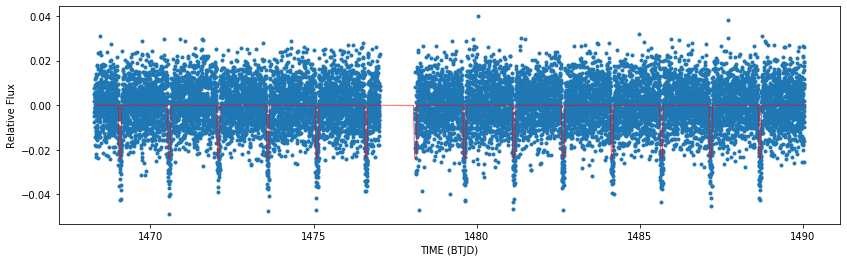

In [88]:
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')

url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)

display(HTML(str(r.content.decode('utf-8'))))

#Part 2: Cutout of the TESS FFIs using Astrocut and Astroquery
With the formed data, we can already gain a lot of information. But visually it does not tell us that much. We just know the phase of the exoplanet. But there is so much more to look at. As for example we can look at stars and visualize them by using TESS FFI (Full frame images). This can give us a good view of what we actually observed. 
For this part I selected a different type of course. Namely, TOI 163 b which gives a possible result with an outcome that we will use later on during the rest of the code. To start the code, we need to achieve the data of that code. This is done by the following code underneath. Where we fill in the TICid of the star, which can be found online (https://exo.mast.stsci.edu).

In [89]:
ticid = 179317684 #TOI 163 b
#It can be that for the first time running this part of the code, it will give an error. If you run the code one more time it resolve it by itself

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
179317684 10.8719 10.404 79.7681542778366 -71.8955973541796    STAR
675718006 19.6769    nan 79.7610354619733 -71.8957001791909    STAR
675718004 18.8899    nan 79.7668511140098 -71.8978766475765    STAR
675718086   19.55    nan 79.7621792830885 -71.8941346227623    STAR
675718070 20.4155    nan 79.7759168807087 -71.8944398456769    STAR


20

From the following part, we can see in which sector(s) the star was observed. This is necessary to know to fill in later to find select a specific part of data. 

In [90]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)

hdulist = Tesscut.get_cutouts(coord, 20)
hdulist[0].info()
hdulist[0][0].header['SECTOR']

hdulist[1].info()
print(sectorTable)

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1245R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-4-2      1      4   2
tess-s0002-4-2      2      4   2
tess-s0003-4-2      3      4   2
tess-s0004-4-3      4      4   3
tess-s0005-4-3      5      4   3
tess-s0006-4-3      6      4   3
tess-s0007-4-4      7      4   4
tess-s0007-4-3      7      4   3
tess-s0008-4-4      8      4  

With that being known and the data accessable from the server, where are able to from the FFI of TOI 163 b. This is done by the following code, where we define a new type of image forming with the data. 

Text(0, 0.5, 'Image Row')

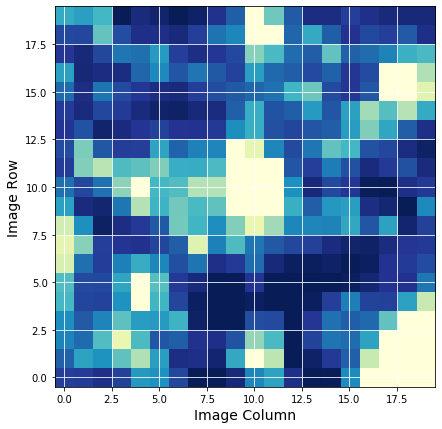

In [91]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)

We can use this diagram then to look at the different objects in the nearby neighboorhood form the selected object what else we can find/indentify. This is showed in the following code, where the selected object gets a red dot and the nearby objects a orange dot. This will be of good use for the last part of the code. 

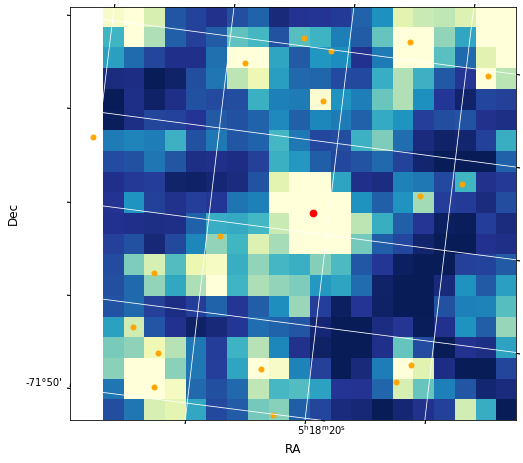

In [92]:
hdu2 = hdulist[1]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

We created two functions. One to appply a photometric aperture to one image and the other to then apply that to all the images in the FLUX array. With that we can eventually form the overall light curve of this formed image, which is programmed underneath. 

Text(0.5, 1.0, 'Flux in Photometric Aperture')

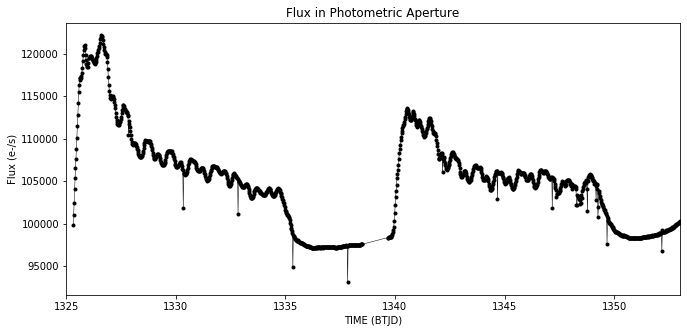

In [93]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux

# Use all pixels in our aperture.
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
plt.xlim(1325, 1353)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')

As shown from the diagram, we can see that the picture has some background. Then it is very useful to get ride of most of the background noise that is formed. This is done in by plotting the flux change of the dimmest pixels by using percentile and eventually (second part) subtract this from the normal formed curve (shown above). 

Text(0.5, 1.0, 'Background Flux')

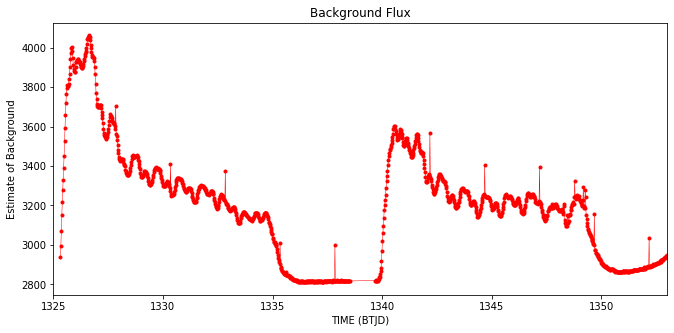

In [94]:
bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1325, 1353)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

Text(0.5, 1.0, 'Background Subtracted Flux')

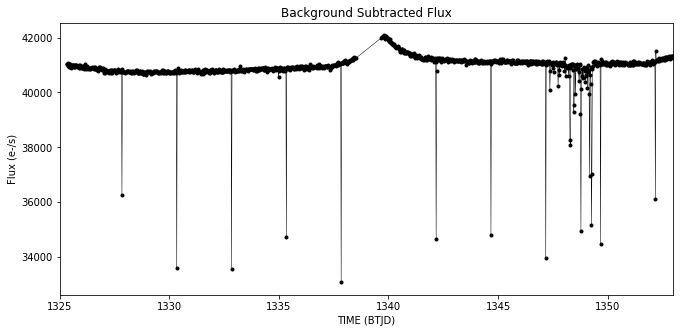

In [95]:
bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.xlim(1325, 1353)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')

With this formed curve we can eventually see the Flux of the object over time. It is a slightly 'weird' curve. Since only specific data points are having a low flux. But interesting to see is that most of these points are repetitive. Which can be an indication for a specific period. Next to that, we can see that right before 1350 BTJD a peculair flucation happened. This can either be a mistake due to the material used measuring the data or some where flux happening at that point (where it is most likely due an change due measurements themselves). 

#Part 3: TESS Time Series Data
Know we have shown that we can use the FFI to form an overal light curve with reduced background noise. But if we want to look at changes over time, like for example a pulsar, we cannot tell that from one image. For that, we need several images shown in a range of time, or a small video where several images are plotted right one after the other. This will be the final part of this of this code. Again, we need to retrieve the data for this. But this can go quite easy, since it would be nice to look again at the TOI 163 b. Since we already found a lot of information around it. 

In [0]:
Tic_id = "179317684" #TOI 163 b#

In [0]:
exomast_url = "https://exo.mast.stsci.edu/api/v0.1/"

In [98]:
list_tce_query = f"{exomast_url}dvdata/tess/{Tic_id}/tces/"
list_tce_query

'https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/179317684/tces/'

In [99]:
response = requests.get(list_tce_query)
tce_dict = response.json()
print(tce_dict)

{'TCE': ['s0013-s0013:TCE_1', 's0012-s0012:TCE_1', 's0011-s0011:TCE_1', 's0009-s0009:TCE_1', 's0010-s0010:TCE_1', 's0001-s0013:TCE_1']}


In [0]:
TIC_sector, TIC_tce = tce_dict['TCE'][0].split(":")

In [101]:
dv_metadata_query = f"{exomast_url}dvdata/tess/{Tic_id}/info/?tce={TIC_tce}&sector={TIC_sector}"
dv_metadata_query

'https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/179317684/info/?tce=TCE_1&sector=s0013-s0013'

In [102]:
response = requests.get(dv_metadata_query)
metadata = response.json()
metadata.keys()

dict_keys(['DV Primary Header', 'DV Data Header', 'DV Data'])

In [103]:
metadata['DV Primary Header'].keys()
metadata['DV Data Header'].keys()

dict_keys(['TICID', 'EXTNAME', 'EXTVER', 'SIMDATA', 'RADESYS', 'RA_OBJ', 'DEC_OBJ', 'EQUINOX', 'EXPOSURE', 'TIMEREF', 'TASSIGN', 'TIMESYS', 'BJDREFI', 'BJDREFF', 'TIMEUNIT', 'TELAPSE', 'LIVETIME', 'TSTART', 'TSTOP', 'DATE_OBS', 'DATE_END', 'DEADC', 'TIMEPIXR', 'TIERRELA', 'INT_TIME', 'READTIME', 'FRAMETIM', 'NUM_FRM', 'TIMEDEL', 'TPERIOD', 'TEPOCH', 'TDEPTH', 'TSNR', 'TDUR', 'INDUR', 'IMPACT', 'INCLIN', 'DRRATIO', 'RADRATIO', 'PRADIUS', 'MAXMES', 'MAXSES', 'NTRANS', 'CONVRGE', 'MEDDETR', 'TESSDatetime', 'SECTORS'])

In [104]:
dv_lightcurve_query = f"{exomast_url}dvdata/tess/{Tic_id}/table/?tce={TIC_tce}&sector={TIC_sector}"
dv_lightcurve_query

'https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/179317684/table/?tce=TCE_1&sector=s0013-s0013'

In [105]:
response = requests.get(dv_lightcurve_query)
data_dict = response.json()
data_dict.keys()

dict_keys(['fields', 'data'])

In [106]:
for col in data_dict['fields']:
    print(f"{col['colname']} {col['datatype']:5} {col['description']}")

TIME                float  column title: data time stamps
TIMECORR            real   column title: barycenter - timeslice correction
CADENCENO           int    column title: unique cadence number
PHASE               real   column title: Phase using period and epoch
LC_INIT             real   column title: Detrended initial light curve (ga
LC_INIT_ERR         real   column title: Error in the detrended initial li
LC_WHITE            real   column title: Initial whitened time series fit
LC_DETREND          real   column title: Initial median detrended time ser
MODEL_INIT          real   column title: Model light curve
MODEL_WHITE         real   column title: Whitened model light curve


In [0]:
def json_to_table(fields, data):
    """"
    Takes a json object and turns it into an astropy table.

    Parameters
    ----------
    fields : list of dicts
        Of the form [{colname:,datatype:,description:}, ...]
    data : list of dicts
       Of the form [{col1:, col2:, ...},{col1:, col2:, ...}, ...]

    Returns
    -------
    response : `astropy.table.Table`
    """

    rx = re.compile(r"varchar\((\d+)\)")
    
    data_table = Table()

    for col, atype in [(x['colname'], x['datatype']) for x in fields]:
        col = col.strip()
        if "varchar" in atype:
            match = rx.search(atype)
            atype = "U" + match.group(1)
        if atype == "real":
            atype = "float"
        data_table[col] = np.array([x.get(col, None) for x in data], dtype=atype)

    return data_table

In the next part, we can see all the different data that is available for the chosen object. From this we can also find the time period wherein the measurements were done. We can use this to eventually find in which period the frames are saved. (1653-1682)

In [108]:
TIC_lightcurve = json_to_table(data_dict['fields'],data_dict['data'])
TIC_lightcurve

TIME,TIMECORR,CADENCENO,PHASE,LC_INIT,LC_INIT_ERR,LC_WHITE,LC_DETREND,MODEL_INIT,MODEL_WHITE
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
1653.9156119326929,0.0005516957608051598,307051,-0.762689471244812,nan,nan,nan,nan,0.0,nan
1653.9170008271003,0.0005517018726095557,307052,-0.7613005638122559,nan,nan,nan,nan,0.0,nan
1653.9183897215162,0.0005517079844139516,307053,-0.7599116563796997,nan,nan,nan,nan,0.0,nan
1653.9197786159425,0.0005517140962183475,307054,-0.7585227489471436,nan,nan,nan,nan,0.0,nan
1653.9211675103768,0.0005517202662304044,307055,-0.7571338415145874,nan,nan,nan,nan,0.0,nan
1653.9225564048209,0.0005517264362424612,307056,-0.755744993686676,nan,nan,nan,nan,0.0,nan
1653.9239452992751,0.0005517325480468571,307057,-0.7543560862541199,nan,nan,nan,nan,0.0,nan
1653.925334193737,0.000551738718058914,307058,-0.7529671788215637,nan,nan,nan,nan,0.0,nan
1653.926723088208,0.0005517448880709708,307059,-0.7515782713890076,nan,nan,nan,nan,0.0,nan


As a check up on the data, we can form a detrended lightcurve. 

In [110]:
bfig = plotting.figure(plot_width=850, plot_height=250, title=f"Detrended Lightcurve (TIC{Tic_id})")
bfig.circle(TIC_lightcurve["PHASE"],TIC_lightcurve["LC_DETREND"], fill_color="black",size=1, line_color=None)
plotting.show(bfig)

In [111]:
ra = metadata['DV Data Header']['RA_OBJ']
dec = metadata['DV Data Header']['DEC_OBJ']
obj_coord = SkyCoord(ra,dec,unit="deg")
print(obj_coord)

<SkyCoord (ICRS): (ra, dec) in deg
    (79.768168, -71.895588)>


In here we can find all the possible sectors to select from for the time series. As a good option it is useful to pick a early sector. Since we know that data is processed properly and is less likely to change. We can easily access that. For the video we eventually choose for sector 1, where the time is given from: 1325-1353.

In [112]:
Tesscut.get_sectors(obj_coord)

sectorName,sector,camera,ccd
str14,int64,int64,int64
tess-s0001-4-2,1,4,2
tess-s0002-4-2,2,4,2
tess-s0003-4-2,3,4,2
tess-s0004-4-3,4,4,3
tess-s0005-4-3,5,4,3
tess-s0006-4-3,6,4,3
tess-s0007-4-4,7,4,4
tess-s0007-4-3,7,4,3
tess-s0008-4-4,8,4,4


In [113]:
cutout_hdu = Tesscut.get_cutouts(obj_coord, size=50)[0]
cutout_hdu.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 2500J, 2500E, 2500E, 2500E, 2500E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (50, 50)   int32   


By defining the different columns, we know which name must be used for forming eventually different plots. Where an example is given right after this part of this code. 

In [114]:
cutout_table = cutout_hdu[1].data
cutout_table.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '2500J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(50, 50)'
    name = 'FLUX'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50, 50)'
    name = 'FLUX_ERR'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50, 50)'
    name = 'FLUX_BKG'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50, 50)'
    name = 'FLUX_BKG_ERR'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50, 50)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'FFI_FILE'; format = '38A'; unit = 'pixel'
)

In [115]:
bfig.circle(TIC_lightcurve["TIME"],TIC_lightcurve["LC_DETREND"], fill_color="black",size=1, line_color=None)
plotting.show(bfig)

In [0]:
def find_index(btjd):
    """
    Given a time as a Barycentric TESS Julian Date (BTJD) timestamp, return the closest index in a table
    that is assumed to have a TIME column that is also in BTJD"""
    
    return (np.abs(cutout_table['TIME'] - btjd)).argmin()

For the start en end of the index we selected a small range within sector 1. This was done, because of the amount of frames. If a large start and end are selected, more frames are given, which much more time to process. That is why for this example we made the decision to take a small range. If you want you can change the value, but it will take more time to process. 

In [117]:
start = find_index(1331)
end = find_index(1332)

print(f"Frames {start}-{end} ({end-start} frames)")

Frames 272-320 (48 frames)


With everything defined, we can make a time series. This is done by the code given under. With that a 'video' is formed eventually. 

In [0]:
def make_animation(data_array, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=50):
    """
    Function that takes an array where each frame is a 2D image array and make an animated plot
    that runs through the frames.
    
    Note: This can take a long time to run if you have a lot of frames.    
    Parameters
    ----------
    data_array : array
        Array of 2D images.
    start_frame : int
        The index of the initial frame to show. Default is the first frame.
    end_frame : int
        The index of the final frame to show. Default is the last frame.
    vmin : float
        Data range min for the colormap. Defaults to data minimum value.
    vmax : float
        Data range max for the colormap. Defaults to data maximum value.
    delay: 
        Delay before the next frame is shown in milliseconds.

    Returns
    -------
    response : `animation.FuncAnimation`
    """
    
    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)
        
    if not end_frame:
        end_frame = len(data_array) - 1 # set to the end of the array
        
    num_frames = end_frame - start_frame + 1 # include the end frame
        
    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Epoch #" + str(i+start))
        im = ax.imshow(binarytab[i+start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return im,
    
    # Create initial plot.
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    ani = animation.FuncAnimation(fig, animate, fargs=(fig, ax, data_array, start_frame), frames=num_frames, 
                                  interval=delay, repeat_delay=1000)
    
    plt.close()
    
    return ani

In [119]:
make_animation(cutout_table['FLUX'], start, end, vmax=500)

When we take a look at the video, we can see in the bottom left of the video, a small pusalting is happening. This a very interesting property to look into. The rest of the code gives a possibility to look at the nearby objects in the frame and give some information about them. Herefore we need to name the different objects. 

In [120]:
sources = Catalogs.query_object(catalog="TIC", objectname=f"TIC {Tic_id}", radius=10*u.arcmin)
sources = sources[sources["Tmag"] < 12]
print(f"Number of sources: {len(sources)}")
print(sources)

Number of sources: 5
    ID           ra               dec        ... wdflag     dstArcSec     
--------- ---------------- ----------------- ... ------ ------------------
179317684 79.7681542778366 -71.8955973541796 ...      0                0.0
141092369 79.7222962137301 -71.9756811055494 ...      0  292.8110833321947
179124163 79.4559507230701 -71.9236965671701 ...      0 363.36361249647416
141092426 79.8526982772749 -72.0067947463968 ...      0  411.2671874767726
179318090 79.8947796830037 -71.7672541440257 ...      0 483.40522137786854


In [0]:
cutout_wcs = WCS(cutout_hdu[2].header)
cutout_img = cutout_table["FLUX"][start]

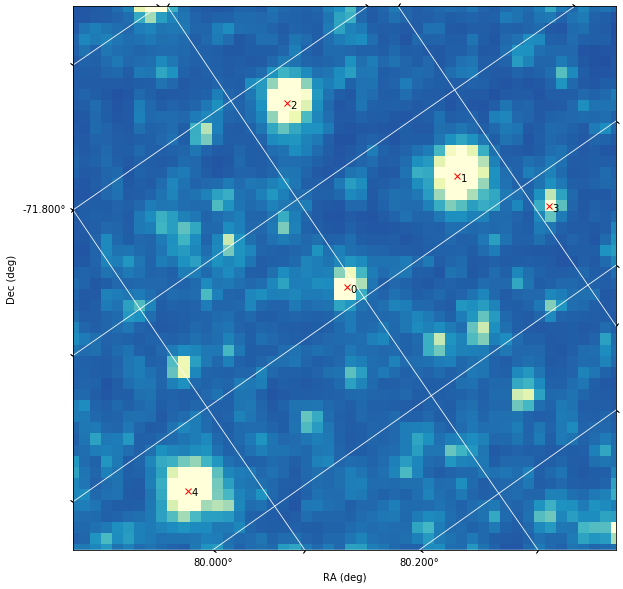

In [122]:
fig, ax = plt.subplots(subplot_kw={'projection':cutout_wcs})
fig.set_size_inches(10,10)
plt.grid(color='white', ls='solid')
    
# Setup WCS axes.
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter('d.ddd')
ycoords.set_major_formatter('d.ddd')
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r,vmin=0,vmax=700)
ax.plot(sources['ra'],sources['dec'],'x',transform=ax.get_transform('icrs'),color="red")

# Annotating the sources with their row nnumber in the sources table
for i,star in enumerate(sources):
    ax.text(star['ra']+0.01,star['dec'],i,transform=ax.get_transform('icrs'))

ax.set_xlim(0,cutout_img.shape[1]-1)
ax.set_ylim(cutout_img.shape[0]-1,0)

plt.show()

With the different surrounding objects being defined, we know that our interst is found at point 4. By selecting it as a source and found the corresponding data for that particular spot, we can form the light curve of it. Which is done in the following part of the code. 

In [123]:
sources["ID","ra","dec"][4] #data retrieved from the point#
variable_tic_id = sources["ID"][4]

variable_res = Observations.query_criteria(target_name=variable_tic_id, 
                                        obs_collection="HLSP", 
                                        filters="TESS")
print(f"Number of tasoc light curves for {variable_tic_id}: {len(variable_res)}\n")

        
variable_prod = Observations.get_product_list(variable_res[0])
variable_manifest = Observations.download_products(variable_prod)

Number of tasoc light curves for 179318090: 2

INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00179318090-s01-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00179318090-s01-c1800_tess_v04_lc.fits with expected size 161280. [astroquery.query]


In [0]:
hdu = fits.open(variable_manifest["Local Path"][0]) #opening the data file#
variable_lc = Table(hdu[1].data)
hdu.close()

In [125]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{variable_tic_id})") #forming the Detrended Light curve of the nearby object#

bfig.circle(variable_lc["TIME"],variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)
bfig.line(variable_lc["TIME"],variable_lc["FLUX_RAW"], line_color='black')

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

From the formed light curve, we can see the time over the flux has again those big jumps in there data. But know we can see that the 'line' that is formed around 47000 is wider then before. This is an indication of a changeable data. It could be even possible to that there is a repetitious flux is happening. Therefore we can look at the frequency, which code is formed here below. 

In [0]:
lomb = LombScargle(variable_lc["TIME"], variable_lc["FLUX_RAW"])
frequency, power = lomb.autopower(maximum_frequency=25)

In [127]:
bfig = plotting.figure(plot_width=850, plot_height=300, x_range=(0,25),
                       title=f"Periodogram (TIC{variable_tic_id})")

bfig.line(frequency, power, line_color='black')

# Labeling the axes
bfig.xaxis.axis_label = "Frequency (1/day)"
bfig.yaxis.axis_label = "Power"

plotting.show(bfig)

This graphs shows that a flucation is happening in the selected part. This is gives an interesting protperty next to the observed object. Which gives us indication to look at this point more. Of course, with the phase and flux throughout the data analysis, is it again interesting to look at them again. It gives on its turn a different interepretation of the data. 


In [128]:
dominant_freq = frequency[np.argmax(power)].value
print(f"The dominant period: {1/dominant_freq*24:.3} hours")

The dominant priod: 3.97 hours


In [129]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Phased Lightcurve (TIC{variable_tic_id})")

# Plotting the phased light curve
bfig.circle(variable_lc["TIME"]%(1/dominant_freq),variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)

# Plotting the periodic fit
t_fit = np.linspace(0,1/dominant_freq,100)
bfig.line(t_fit, lomb.model(t_fit, dominant_freq), color='#1b9f00', line_width=2)

# Labeling the axes
bfig.xaxis.axis_label = "Phase (days)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

With this final curve, we can see that a slight in and decrease in the flux over the phase. This can be an indication of the object being rotating around another object. But again, a bigger analysis would be need to find specifical what we are dealing with. This are just small speculations around the new found object. 

With that being said, end this analysis of the data. We have seen several techniques and possibilities what can be done with data achieved from TESS. These analysis can also be done on other objects which can find other exoplanets, pulsars and so on. It gives a lot of opportunities. 